### Pipeline for panorama generation from a sequence of agricultural images

In [1]:
import cv2
import matplotlib.pyplot as plt
from image_stitching import run_stitching_pipeline

/Users/mason/Documents/ucd/code/Ground-Imagery-Alignment/Panorama-Maker/test_env/lib/python3.12/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)
/Users/mason/Documents/ucd/code/Ground-Imagery-Alignment/Panorama-Maker/LightGlue/lightglue/lightglue.py:24: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


Be sure to update the `config.yaml` file to point to the desired directory. The files should contain a sequential numbering as part of the file name. This numbering is assumed to be a timestamp.

In [2]:
# Run the stitching pipeline using the configuration file
panorama = run_stitching_pipeline("config.yaml")

Running image stitching pipeline...
Configuration loaded successfully.
Found 10 images to process.
Sorted Image Paths: ['../data/kramlich-subset/rgb/device_741df78f3cf22b9e_camera1_1722960517894.jpg', '../data/kramlich-subset/rgb/device_741df78f3cf22b9e_camera1_1722960517996.jpg', '../data/kramlich-subset/rgb/device_741df78f3cf22b9e_camera1_1722960518099.jpg', '../data/kramlich-subset/rgb/device_741df78f3cf22b9e_camera1_1722960518205.jpg', '../data/kramlich-subset/rgb/device_741df78f3cf22b9e_camera1_1722960518310.jpg', '../data/kramlich-subset/rgb/device_741df78f3cf22b9e_camera1_1722960518439.jpg', '../data/kramlich-subset/rgb/device_741df78f3cf22b9e_camera1_1722960518541.jpg', '../data/kramlich-subset/rgb/device_741df78f3cf22b9e_camera1_1722960518644.jpg', '../data/kramlich-subset/rgb/device_741df78f3cf22b9e_camera1_1722960518746.jpg', '../data/kramlich-subset/rgb/device_741df78f3cf22b9e_camera1_1722960518851.jpg']
Found 10 depth maps.
Processing images and depth maps...
Processing im

Display the panorama generated by the pipeline.

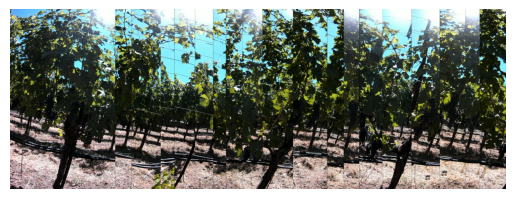

In [22]:
plt.imshow(cv2.cvtColor(panorama, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

Write the panorama as a png file

In [6]:
# Save the final panorama
cv2.imwrite('../output/stitched_panorama_kaziga1_subsample.png', panorama)

True

### Testing out depthanythingv2

In [45]:
import os
import torch
import numpy as np
from PIL import Image
from transformers import AutoImageProcessor, AutoModelForDepthEstimation


# Load the model and image processor
image_processor = AutoImageProcessor.from_pretrained("depth-anything/Depth-Anything-V2-Small-hf")
model = AutoModelForDepthEstimation.from_pretrained("depth-anything/Depth-Anything-V2-Small-hf")

# Define the directory and load a subset of images
directory = "../data/kramlich-subset/rgb"  # Update with your local directory
image_paths = os.listdir(directory)  # List all files in the directory
image_paths = [os.path.join(directory, img) for img in image_paths if img.endswith(('.png', '.jpg', '.jpeg'))]

# Sort the image paths alphanumerically
image_paths.sort()

# Subset of images (e.g., first 5 images)
subset_image_paths = image_paths  # Adjust this to the desired number of images

In [46]:
# Load and preprocess all images in the subset as a batch
images = [Image.open(img_path) for img_path in subset_image_paths]
inputs = image_processor(images=images, return_tensors="pt")  # Batch processing here

In [47]:
# Perform inference with the depth estimation model for the entire batch
with torch.no_grad():
    outputs = model(**inputs)
    predicted_depths = outputs.predicted_depth

In [48]:
# Interpolate the depth predictions to the original sizes of the images
predicted_depths = torch.nn.functional.interpolate(
    predicted_depths.unsqueeze(1), 
    size=images[0].size[::-1],  # Assuming all images are of the same size. Modify if needed.
    mode="bicubic", 
    align_corners=False
)

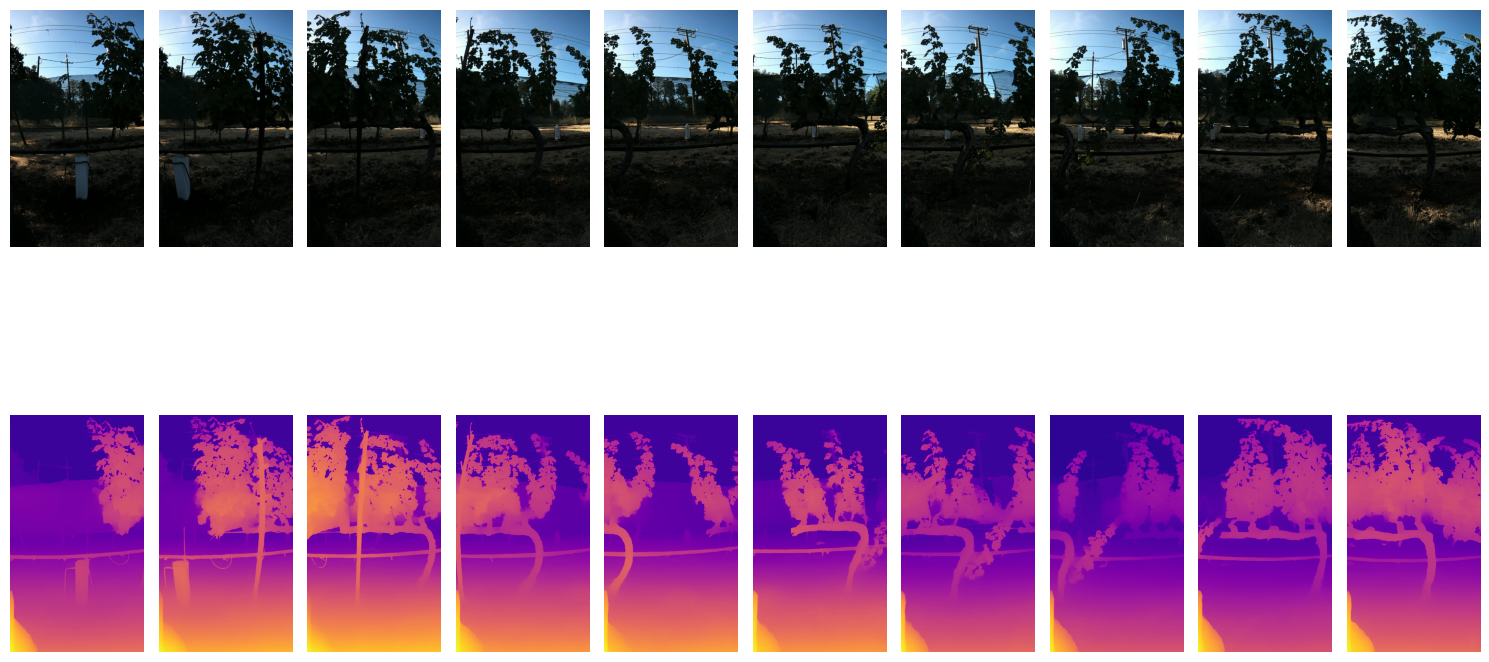

In [58]:
import matplotlib.pyplot as plt
import tifffile as tiff

# Create a grid of images to visualize the original images and the predicted depth maps
fig, axes = plt.subplots(2, len(subset_image_paths), figsize=(15, 10))  # Adjust the figsize as needed

# Display original images
for i, img_path in enumerate(subset_image_paths):
    original_image = Image.open(img_path)
    axes[0, i].imshow(original_image)
    axes[0, i].axis('off')  # Hide axes for a cleaner look

output_dir = '../data/kramlich-subset/depth'
for i, image_path in enumerate(subset_image_paths):
    image_name = image_path.split('/')[-1].split('.')[0]  # Extract the file name from the image path
    output = predicted_depths[i].squeeze().cpu().numpy()
    
    # Save as 32-bit floating point TIFF
    tiff.imwrite(f"{output_dir}/{image_name}.tiff", output.astype('float32'), dtype='float32')
    
    # Visualization for display (not saving)
    axes[1, i].imshow(output, cmap='plasma')  # Use colormap for visualization
    axes[1, i].axis('off')  # Hide axes for a cleaner look

plt.tight_layout()
plt.show()

    
